In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

In [1]:
import antigranular as ag
ag_client = ag.login(ag_client_id="ag_client_id", ag_client_secret="ag_client_secret", x_oblv_name="CDl6m0dfjtOPYzZUkvSDznKMKWVaEGCg", dataset="Car Evaluation")

TypeError: login() got an unexpected keyword argument 'dataset'

In [ ]:
%%ag
from ag_util import load_dataset
car_evaluation = load_dataset("Car Evaluation")

In [3]:
%%ag
import pandas as pd

In [4]:
%%ag
train_x = car_evaluation["train_x"]
train_y = car_evaluation["train_y"]
test_x = car_evaluation["test_x"]

ag_print(train_x.columns)
ag_print(train_y.columns)

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')
Index(['class'], dtype='object')



In [5]:
session.privacy_odometer()

{'total_epsilon_used': 0.0,
 'total_delta_used': 0.0,
 'library_costs': None,
 'dataset_costs': None}

## Data Preprocessing

In [6]:
%%ag
unique_categories = {}
for column in test_x.columns:
    unique_categories.update({column: test_x[column].unique().tolist()})
ag_print(unique_categories)


{'buying': ['high', 'med', 'low', 'vhigh'], 'maint': ['high', 'low', 'vhigh', 'med'], 'doors': ['4', '2', '5more', '3'], 'persons': ['2', '4', 'more'], 'lug_boot': ['med', 'big', 'small'], 'safety': ['high', 'med', 'low']}



In [7]:
%%ag
encoding_scheme_train_x_gen = {}

for column, values in unique_categories.items():
    encoding_scheme_train_x_gen[column] = {value: idx for idx, value in zip(range(len(values)), values)}

ag_print(encoding_scheme_train_x_gen)

{'buying': {'high': 0, 'med': 1, 'low': 2, 'vhigh': 3}, 'maint': {'high': 0, 'low': 1, 'vhigh': 2, 'med': 3}, 'doors': {'4': 0, '2': 1, '5more': 2, '3': 3}, 'persons': {'2': 0, '4': 1, 'more': 2}, 'lug_boot': {'med': 0, 'big': 1, 'small': 2}, 'safety': {'high': 0, 'med': 1, 'low': 2}}



In [8]:
%%ag
encoding_scheme_train_x = {'buying': {'high': 2, 'med': 1, 'low': 0, 'vhigh': 3}, 'maint': {'high': 2, 'low': 0, 'vhigh': 3, 'med': 1}, 'doors': {'4': 2, '2': 0, '5more': 2, '3': 1}, 'persons': {'2': 0, '4': 1, 'more': 2}, 'lug_boot': {'med': 1, 'big': 2, 'small': 0}, 'safety': {'high': 2, 'med': 1, 'low': 0}}


In [9]:
%%ag
ag_print(encoding_scheme_train_x)

{'buying': {'high': 2, 'med': 1, 'low': 0, 'vhigh': 3}, 'maint': {'high': 2, 'low': 0, 'vhigh': 3, 'med': 1}, 'doors': {'4': 2, '2': 0, '5more': 2, '3': 1}, 'persons': {'2': 0, '4': 1, 'more': 2}, 'lug_boot': {'med': 1, 'big': 2, 'small': 0}, 'safety': {'high': 2, 'med': 1, 'low': 0}}



Apply Encoding for train_x

In [10]:
%%ag
for col, value in encoding_scheme_train_x.items():
    train_x[col] = train_x[col].map(value, eps=1)

Apply encoding train_y

In [11]:
%%ag
train_y_schema = {
    'unacc': 0,
    'acc': 1,
    'good': 2,
    'vgood': 3
}

train_y[train_y.columns[0]] = train_y[train_y.columns[0]].map(train_y_schema, eps=1)

In [12]:
%%ag
ag_print(train_y.describe(eps=.1))

             class
count  1247.000000
mean      0.866890
std       0.960902
min       0.396653
25%       0.282038
50%       0.412205
75%       2.045419
max       2.314112



## Data Visualization

Join two dataset train_x and train_y

In [13]:
%%ag
train_data = train_x.join(train_y, how="inner")

In [14]:
%%ag
import op_snsql

In [15]:
%%ag
privacy = op_snsql.Privacy(epsilon=1.0)
reader = op_snsql.from_df(df=train_data, privacy=privacy)

In [16]:
%%ag
result = reader.execute("SELECT class, AVG(buying), AVG(maint), AVG(doors), AVG(persons), AVG(lug_boot), AVG(safety) FROM df.table GROUP BY class")
export(result, 'result')

Setting up exported variable in local environment: result


In [17]:
%%ag
export(train_x.columns, 'train_x_columns')

Setting up exported variable in local environment: train_x_columns


In [18]:
new_columns = ['class'] + train_x_columns.tolist()
df = pd.DataFrame(result[1:], columns=new_columns)

In [19]:
df

,class,buying,maint,doors,persons,lug_boot,safety
0,0,1.609631,1.642343,1.205943,0.812950,0.932099,0.736410
1,1,1.465116,1.400662,1.341060,1.466887,1.106312,1.541528
2,2,0.517241,0.372881,1.189655,1.431034,1.066667,1.396552
3,3,0.477273,0.816327,1.479167,1.553191,1.791667,1.958333


In [20]:
df.drop(columns=['class'], inplace=True)

<Axes: >

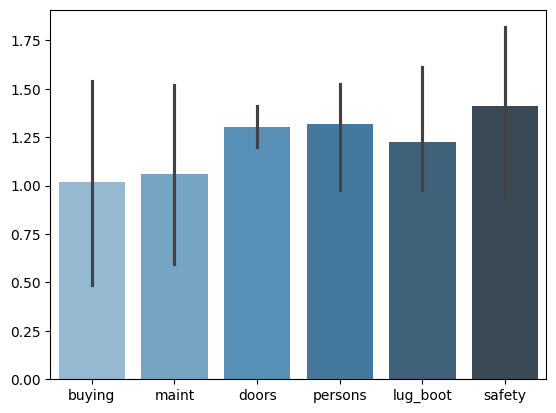

In [21]:
# sns barplot
sns.barplot(data=df, palette="Blues_d")

Observations:

- **buying**: There are noticeable differences in the mean buying price among different classes.
- **maint**: Similar to buying, maintenance cost also shows some variation.
- **safety**: Safety shows clear variations, and looks like ***most important***.
  
The remaining features (**doors**, **persons**, **lug_boot**) exhibit less variation among classes.

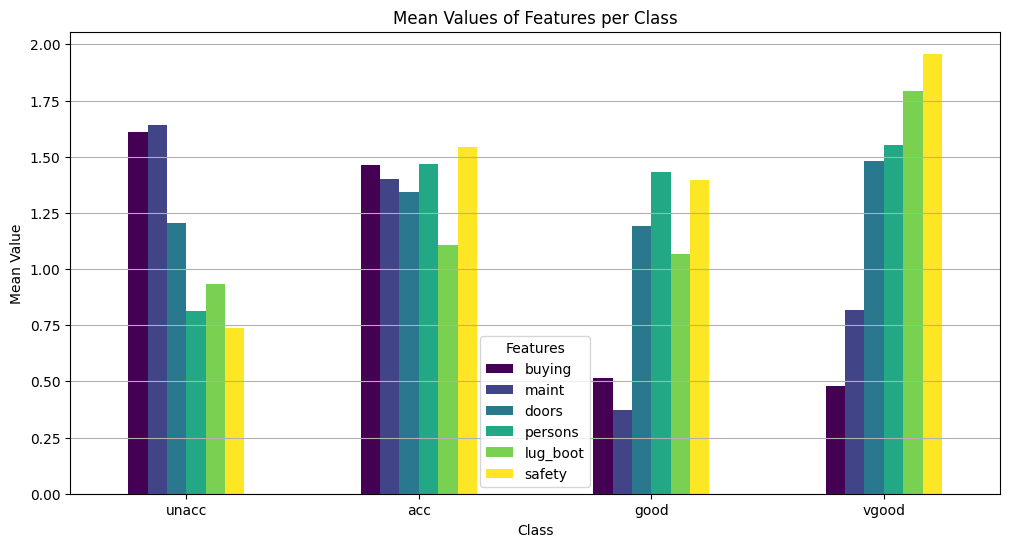

In [22]:
ax = df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Mean Values of Features per Class')
plt.xlabel('Class')
plt.ylabel('Mean Value')
plt.xticks(ticks=[0, 1, 2, 3], labels=['unacc', 'acc', 'good', 'vgood'], rotation=0)
plt.legend(title='Features')
plt.grid(axis='y')

## Observations:
1. **Safety Considerations:**
   - 'vgood' cars tend to have the highest mean safety rating, suggesting that safety is a crucial factor in determining the highest class of cars.
   - 'unacc' (unacceptable) cars have the lowest mean safety rating, highlighting that lower safety ratings are a significant factor for classifying cars into this undesirable category.

2. **Economic Aspects (Buying & Maintenance):**
   - 'unacc' cars tend to have higher mean buying and maintenance costs, indicating that more expensive and high-maintenance cars are often deemed less acceptable.
   - 'good' cars have the lowest mean buying and maintenance costs, hinting that more economically friendly cars are often classified in this category.

3. **Luggage Boot Size:**
   - 'vgood' cars have the highest mean luggage boot size, showing a potential preference for larger boot sizes in this class.
   - The other classes do not show significant variations in the luggage boot size.

4. **Capacity (Persons & Doors):**
   - 'unacc' cars have a lower mean value for persons, suggesting that cars with lower seating capacity tend to be categorized as unacceptable.
   - There isn't a clear pattern for the number of doors across classes, implying that this feature might not be as impactful in classifying cars.

### Summary:

- Safety is a pivotal factor across all classes, with higher safety ratings generally correlating with more favorable classes.
- Economic aspects (buying and maintenance costs) appear to significantly impact the classification, especially distinguishing 'unacc' and 'good' cars.
- Features like the number of doors might not be significant in determining car classes due to the lack of clear variation across different classes.

This analysis could inform the feature selection or weighting in a predictive model, focusing on safety and economic aspects as potentially influential variables.

In [23]:
%%ag
ag_print(train_data['class'].describe(eps=1))

count    1383.000000
mean        0.421174
std         0.439611
min         0.096183
25%         0.305881
50%         0.541340
75%         0.895137
max         3.229395
Name: series, dtype: float64



In [24]:
session.privacy_odometer()

{'total_epsilon_used': 21.1,
 'total_delta_used': 1.5543122344752192e-15,
 'library_costs': None,
 'dataset_costs': None}

## Rule based Model

In [25]:
%%ag
# encode test x
for col, value in encoding_scheme_train_x.items():
    test_x[col] = test_x[col].map(value)

In [26]:
%%ag
ag_print(test_x)

     buying  maint  doors  persons  lug_boot  safety
0         2      2      2        0         1       2
1         1      0      0        1         1       1
2         2      2      2        0         2       1
3         0      2      2        1         1       1
4         1      0      2        2         1       0
..      ...    ...    ...      ...       ...     ...
341       3      3      2        2         0       1
342       3      1      2        0         1       1
343       1      0      0        2         0       0
344       3      3      2        2         0       2
345       1      1      0        0         1       1

[346 rows x 6 columns]



In [27]:
%%ag
result = reader.execute("SELECT count(class) FROM df.table GROUP BY class")


In [28]:
%%ag
ag_print(result)

[['???'], [975], [301], [58], [51]]



In [29]:
%%ag
export(result, 'result')

Setting up exported variable in local environment: result


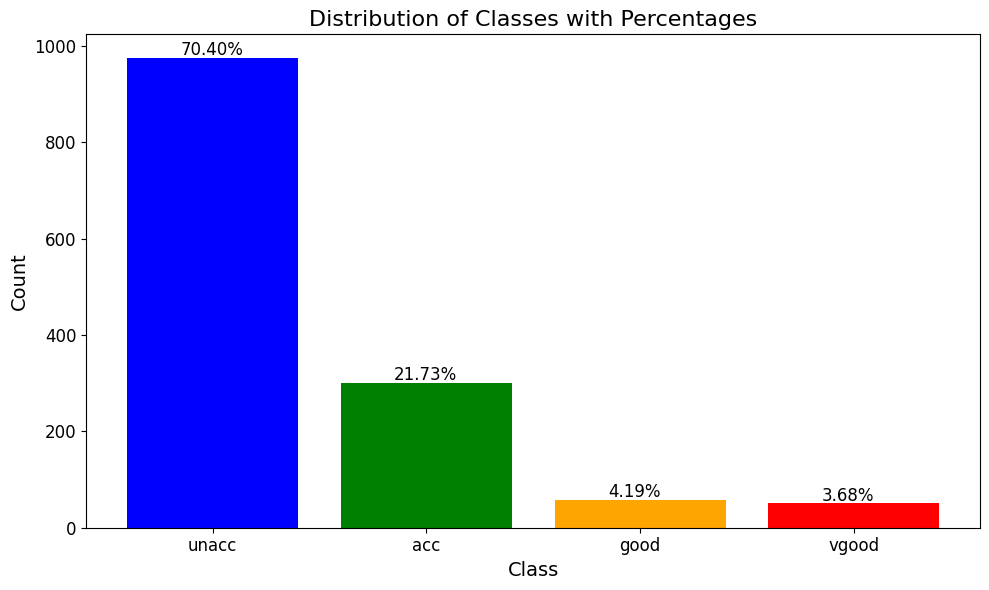

In [30]:
data_counts = [item[0] for item in result[1:]]
labels = ['unacc', 'acc', 'good', 'vgood']

total_count = sum(data_counts)

# Calculate percentages
percentages = [(count/total_count)*100 for count in data_counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, data_counts, color=['blue', 'green', 'orange', 'red'])

for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, # position percentage at the top
             bar.get_height() + 5,
             f'{percentage:.2f}%',
             fontsize=12)

plt.title('Distribution of Classes with Percentages', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


### Observations:
* The data is imbalanced, with the 'unacc' category dominating the distribution.
* 'vgood' and 'good' categories are considerably very less frequent in the data.

The class 'unacc' has the highest count and represents the majority of the data, hence can be default for rule based model

In [31]:
%%ag
# simple rule based
def rule_based_model(data):
    predictions = []
    for _, row in data.iterrows():
        if row['safety'] == 0:
            predictions.append('unacc')
        elif row['buying'] == 0 and row['maint'] == 0:
            predictions.append('acc')
        else:
            predictions.append('unacc')
    return predictions

In [32]:
%%ag
predictions = rule_based_model(test_x)

In [33]:
%%ag
submit_predictions(pd.DataFrame(predictions))

error: (400, 'Dimensions of user provided data does not match with test data')



In [34]:
session.terminate_session()

{'status': 'ok'}